In [9]:
# ---
# title: Data Analysis and Visualization
# author: Your Name
# date: 2023-09-09
# ---

# Setup

import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# ------------------------------------------------------------------------------
# ------------------------------------------------------------------------------
# -----------------------------  USER INPUT  -----------------------------------
# ------------------------------------------------------------------------------
# ------------------------------------------------------------------------------

# we expect the data file to be named like this:
# tstCDC_2023_09_08-11_07_30.txt
# where the date and time are the start time of the data
# this is important to align the data with the other data sets
DATA_FILE = 'tstCDC_2023_09_11-17_51_10.txt'
# start time of the data so that we can align everything

START_TIME = dt.datetime(2023, 9, 11, 17, 51, 10)  # Start time from your data

TEMPERATURE_LOG_FILE = 'temperature_2023-09-11_15-52-07.log'

FLUKE_8588A_LOG = 'RECORD_20230912071854.csv'

# ------------------------------------------------------------------------------
# ------------------------------------------------------------------------------
# --------------------------  END OF USER INPUT  -------------------------------
# ------------------------------------------------------------------------------
# ------------------------------------------------------------------------------


# assert the start time coincides with the time in the name of the data file
assert DATA_FILE[7:26] == START_TIME.strftime('%Y_%m_%d-%H_%M_%S')

# Define a function to remove outliers
def remove_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]


# we use a centered moving average to smooth the data withour introducing a lag
def centered_moving_average(data, window_size):
    """Compute a centered moving average."""
    half_window = window_size // 2
    extended_data = np.pad(data, (half_window, half_window), mode='edge')
    cumsum = np.cumsum(extended_data)
    
    # Subtract the cumulated sum shifted by the window size from the cumulated sum 
    # to get the sum over the window for each point
    sum_window = cumsum[window_size:] - cumsum[:-window_size]
    return sum_window / window_size

import numpy as np

def compute_normalized_xcorr(signal1, signal2, mode='full'):
    """
    Compute the normalized cross-correlation between two signals.
    
    Parameters:
    - signal1, signal2: Input signals to compute the cross-correlation for.
    - mode: Type of cross-correlation ('valid', 'full', 'same'). 
            'full' by default, for the complete cross-correlation.
    
    Returns:
    - cross_corr_normalized: Normalized cross-correlation values.
    - lags: Corresponding lags for the cross-correlation values.
    """
    
    # Centering the signals around their means
    signal1_centered = signal1 - np.mean(signal1)
    signal2_centered = signal2 - np.mean(signal2)

    # Computing the cross-correlation
    cross_corr = np.correlate(signal1_centered, signal2_centered, mode=mode)

    # Normalizing using auto-correlations at lag zero
    norm_term = np.sqrt(np.sum(signal1_centered**2) * np.sum(signal2_centered**2))
    cross_corr_normalized = cross_corr / norm_term

    # Creating the lags array
    lags = np.arange(-(len(signal2) - 1), len(signal1))
    
    if mode == 'same':
        lags = np.arange(-(len(signal2) // 2), len(signal1) - len(signal2) // 2 + 1)
    elif mode == 'valid':
        lags = np.arange(0, len(signal1) - len(signal2) + 1)

    return cross_corr_normalized, lags


In [10]:
# Step 0: Load Data
external_temps = {}
with open(TEMPERATURE_LOG_FILE, 'r', encoding='utf-8') as f:
    for line in f:
        if line.strip():  # Check if line is not empty
            parts = line.split('\t')
            timestamp = dt.datetime.strptime(parts[0], '%Y-%m-%d %H:%M:%S')
            for part in parts[1:]:
                if ':' in part:
                    module, temp = part.split(':')
                    module = module.strip()
                    temp = float(temp.strip())
                    if module not in external_temps:
                        external_temps[module] = []
                    external_temps[module].append((timestamp, temp))

# fixed the timezone in the CDC, so now data is in geneva local time


with open(DATA_FILE, 'r', encoding="utf-8" ) as f:
    data_str = f.read()

data = np.array([list(map(float, line.split())) for line in data_str.split('\n') if line])

V1, V2, R = data[:,0], data[:,1], data[:,2]

aligned_temps = {module: [] for module in external_temps}
for module, data in external_temps.items():
    current_idx = 0
    for second in range(len(V1)):  # Assuming V1 is the array you provided in the code snippet
        current_time = START_TIME + dt.timedelta(seconds=second)
        while current_idx < len(data) - 1 and data[current_idx + 1][0] <= current_time:
            current_idx += 1
        aligned_temps[module].append(data[current_idx][1])

# smoothed controller temperature to 1000 points
controller_temp_smoothed = centered_moving_average(aligned_temps['controller'], 1000)

# now we extract and align the data from the Fluke 8588A
# the data is in a csv file with the following format:
# voltage, ???

# we have to align to trigger number 170, as the meaningful data starts there. This corresponds to the first data in the tstCDC file
# we also have to remove the first 170 data points from the Fluke data, as they are not meaningful

with open(FLUKE_8588A_LOG, 'r', encoding="utf-8" ) as f:
    data_str = f.read()

# remove the first 170 data points plus the first line, which is the header
data_str = '\n'.join(data_str.split('\n')[170:])


fluke_data = np.array([list(map(float, line.split(','))) for line in data_str.split('\n') if line])

# we actually care only about the voltage, so we extract that
fluke_data = fluke_data[:,0]


# we should trim the fluke data to the same length as the other data
fluke_data = fluke_data[:len(V1)]

In [11]:
# plot V1 and V2 vs Fluke data

plt.figure(figsize=(6,5))
plt.plot(fluke_data,linewidth=10) 
plt.tick_params('y')

plt.plot(V1)
plt.plot(V2, color='C3')

# zoom in the first 20 data points
plt.xlim(0,20)

plt.title('V1 and V2 vs Fluke data in phase')

# set integer x ticks
plt.xticks(np.arange(0, 21, 2))

plt.tight_layout()
plt.show()

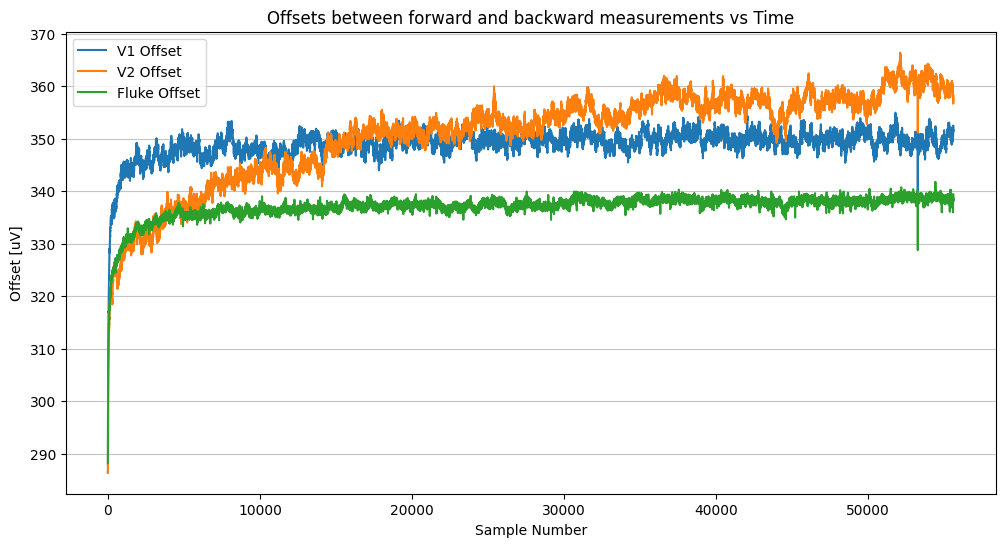

In [12]:


V1_offset =  np.repeat((V1[::2] + V1[1::2]) / 2 , 2)
V2_offset =  np.repeat((V2[::2] + V2[1::2]) / 2 , 2)
Vfluke_offset = np.repeat((fluke_data[::2] + fluke_data[1::2]) / 2 , 2)

V1_no_offset = V1 - V1_offset
V2_no_offset = V2 - V2_offset
Vfluke_no_offset = fluke_data - Vfluke_offset

V_final = np.absolute((V1_no_offset + V2_no_offset) / 2) 
# Step 2: Convert Resistance to Temperature (simplified for example)
Temperature = (R - 100) / 0.385  # A simple linear relationship for PT100 between 0°C and 100°C
 
# Create an array for lags
lags = np.arange(-len(V_final) + 1, len(V_final))

# Convert V_final to ppm
V_final_avg = np.mean(V_final)
V_final_ppm = (V_final - V_final_avg) * 1e6 / V_final_avg

# Define a function to remove outliers
def remove_outliers(data):
    Q1 = np.percentile(data, 15)
    Q3 = np.percentile(data, 85)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]

V_final_ppm_filtered = remove_outliers(V_final_ppm)

V_final_ppm_filtered_avg = centered_moving_average(V_final_ppm_filtered, 100)

def plot_offsets_vs_time():
    # Plot the offsets vs time
    plt.figure(figsize=(12, 6))
    plt.plot(V1_offset*1e6, label='V1 Offset')
    plt.plot(V2_offset*1e6, label='V2 Offset')
    plt.plot(Vfluke_offset*1e6, label='Fluke Offset')
    plt.title('Offsets between forward and backward measurements vs Time')
    plt.xlabel('Sample Number')
    plt.ylabel('Offset [uV]')
    plt.legend()


plot_offsets_vs_time()
plt.grid(axis='y', alpha=0.75)
plt.savefig('img/offsets_vs_time.png')
plt.show()


In [13]:
# rectify and compare the three signals, also remove the outliers

plt.figure(figsize=(12, 8))

plt.plot(remove_outliers(np.absolute(Vfluke_no_offset)), label='Fluke')
plt.plot(remove_outliers(np.absolute(V2_no_offset)), label='V2')
plt.plot(remove_outliers(np.absolute(V1_no_offset)), label='V1')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.title('Rectified Signals with offsets removed')
plt.xlabel('Sample Number')
plt.ylabel('Voltage [V]')
plt.savefig('img/rectified_signals.png')
plt.show()

Max ppm deviation V1 - V2:  1.8393495917450815
Max ppm deviation V1 - Fluke:  2.9334627047326967
Max ppm deviation V2 - Fluke:  1.5654464459344428


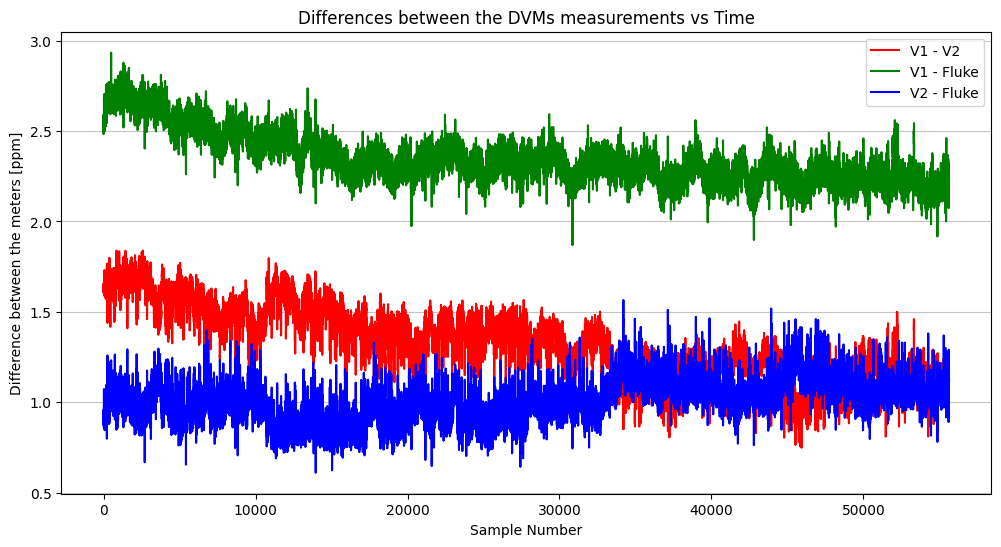

In [14]:
# we want to calculate the ppm deviation of the difference of the meters with respect to the mean of V_final

ppm_deviation = np.absolute(V1_no_offset - V2_no_offset) * 1e6 / V_final_avg
ppm_v1_vs_fluke = np.absolute(V1_no_offset - Vfluke_no_offset) * 1e6 / V_final_avg
ppm_v2_vs_fluke = np.absolute(V2_no_offset - Vfluke_no_offset) * 1e6 / V_final_avg

ppm_deviation_smoothed = centered_moving_average(ppm_deviation, 1000)
ppm_v1_vs_fluke_smoothed = centered_moving_average(ppm_v1_vs_fluke, 1000)
ppm_v2_vs_fluke_smoothed = centered_moving_average(ppm_v2_vs_fluke, 1000)


fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(ppm_deviation, label='V1 - V2', color='r')
ax1.plot(ppm_v1_vs_fluke, label='V1 - Fluke', color='g')
ax1.plot(ppm_v2_vs_fluke, label='V2 - Fluke', color='b')
ax1.set_xlabel('Sample Number')
ax1.set_ylabel('Difference between the meters [ppm]')
ax1.legend(loc='upper right')


plt.title('Differences between the DVMs measurements vs Time')

# print max ppm deviation for each delta
print('Max ppm deviation V1 - V2: ', np.max(ppm_deviation))
print('Max ppm deviation V1 - Fluke: ', np.max(ppm_v1_vs_fluke))
print('Max ppm deviation V2 - Fluke: ', np.max(ppm_v2_vs_fluke))


plt.savefig('img/differences_V1_V2_vs_time.png')
plt.grid(axis='y', alpha=0.75)
plt.show()


In [17]:
# we now want to measure the lag between the controller temperature and the differences between V1_no_offset and V2_no_offset
# we use cross-correlation to do that

# Compute the cross-correlation between the controller temperature and the differences between V1_no_offset and V2_no_offset

cross_corr, lags = compute_normalized_xcorr(controller_temp_smoothed, ppm_deviation_smoothed, mode='full')

# Plot the cross-correlation
plt.figure(figsize=(12, 6))
plt.plot(lags, cross_corr)

# highlight the maximum cross-correlation
max_corr_idx = np.argmax(cross_corr)
plt.plot(lags[max_corr_idx], cross_corr[max_corr_idx], 'ro')
plt.text(lags[max_corr_idx], cross_corr[max_corr_idx], f'Max xcorr lag: {lags[max_corr_idx]}', fontsize=12, color='r')

plt.title('Cross-correlation between controller temperature and differences between V1_no_offset and V2_no_offset')
plt.xlabel('Lag [samples]')
plt.ylabel('Cross-correlation')

plt.savefig('img/cross_correlation_temperature_and_V1-V2.png')

plt.show()


In [16]:
# Plot the two offsets to compare with resistor Temperature
plt.figure(figsize=(12, 6))
# use two different y-axis
ax1 = plt.gca()
ax2 = ax1.twinx() 
# filter the offsets 
V1_offset_filtered = centered_moving_average(V1_offset, 100)
V2_offset_filtered = centered_moving_average(V2_offset, 100)
Vfluke_offset_filtered = centered_moving_average(Vfluke_offset, 100)

ax1.plot(V1_offset*1e6, label='V1 Offset', color='C1')
ax1.plot(V2_offset*1e6, label='V2 Offset', color='C2')
ax1.plot(Vfluke_offset*1e6, label='Fluke Offset', color='C3')
ax1.set_ylabel('Offset between forward and backward [uV]')
ax1.legend(loc='lower right')
ax2.plot(Temperature, label='Temperature', color='C0')
ax2.set_ylabel('Temperature [°C]')

plt.xlabel('Sample Number')

plt.title('Offsets between forward and backward measurements vs Temperature')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.savefig('img/offsets_vs_temperature.png')
plt.show()


In [17]:

# Plot 1
plt.figure(figsize=(12, 6))
plt.plot(V_final, label='Avg between V1 and V2')
plt.title('Average between V1 and V2 with offset removed')
plt.xlabel('Sample Number')
plt.ylabel('Value [V]')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.savefig('img/average_v_final_no_offset.png')
plt.show()


Maximum ppm excursion:  0.6223949162454551
During 15.39 hours


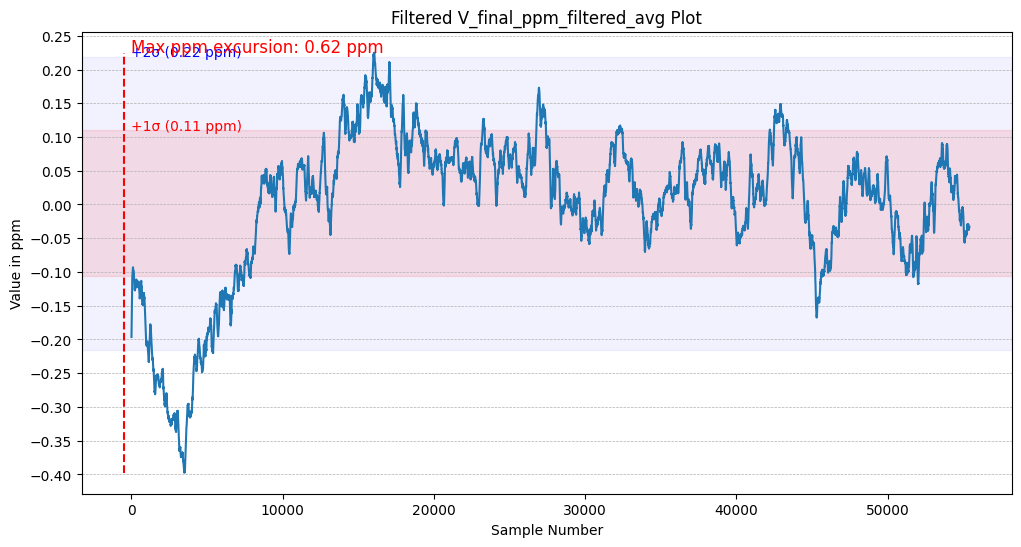

Maximum ppm excursion during a 12 hours window:  0.6223949162454551


In [18]:

# Plot 2
plt.figure(figsize=(12, 6))
sigma = np.std(V_final_ppm_filtered_avg)
mean = np.mean(V_final_ppm_filtered_avg)

# 1 Sigma bands
plt.axhspan(mean - sigma, mean + sigma, color='red', alpha=0.1, label='1 Sigma') 
plt.text(0, mean + sigma, f'+1σ ({sigma:.2f} ppm)', color='r', horizontalalignment='left')

# 2 Sigma bands
plt.axhspan(mean - 2*sigma, mean + 2*sigma, color='blue', alpha=0.05, label='2 Sigma')
plt.text(0, mean + 2*sigma, f'+2σ ({2*sigma:.2f} ppm)',  color='b', horizontalalignment='left')

plt.plot(V_final_ppm_filtered_avg, label='V_final_ppm_filtered_avg')

ticks_interval = 0.05  # spacing in ppm
max_val = np.ceil(np.max(np.abs(V_final_ppm_filtered_avg)) / ticks_interval) * ticks_interval
y_ticks = np.arange(-max_val, max_val + ticks_interval, ticks_interval)
plt.yticks(y_ticks)

plt.grid(axis='y', linestyle='--', linewidth=0.5)

max_ppm_excursion = np.max(V_final_ppm_filtered_avg) - np.min(V_final_ppm_filtered_avg)
# print max ppm excursion
print('Maximum ppm excursion: ', np.max(V_final_ppm_filtered_avg) - np.min(V_final_ppm_filtered_avg))
print(f'During {len(V_final_ppm_filtered_avg)/3600} hours')

# highlight the maximum ppm excursion and quote the value on the plot

max_ppm_excursion_idx = np.argmax(V_final_ppm_filtered_avg)
plt.plot([-500,-500], [np.min(V_final_ppm_filtered_avg), np.max(V_final_ppm_filtered_avg)], 'r--')
plt.text( 0, V_final_ppm_filtered_avg[max_ppm_excursion_idx], f'Max ppm excursion: {max_ppm_excursion:.2f} ppm', fontsize=12, color='r')

plt.title('Filtered V_final_ppm_filtered_avg Plot')
plt.xlabel('Sample Number')
plt.ylabel('Value in ppm')
plt.savefig('img/filtered_v_final_ppm_filtered_avg.png')
plt.show()

# look for the worst case ppm excursion during a window of 12 hours
window_size = 12 * 3600
max_ppm_excursion = 0
for i in range(len(V_final_ppm_filtered_avg) - window_size):
    excursion = np.max(V_final_ppm_filtered_avg[i:i+window_size]) - np.min(V_final_ppm_filtered_avg[i:i+window_size])
    if excursion > max_ppm_excursion:
        max_ppm_excursion = excursion
print('Maximum ppm excursion during a 12 hours window: ', max_ppm_excursion)



sigma: 0.07 ppm, mean: 0.00 ppm
Maximum ppm excursion:  0.3480763356609191
During 15.449444444444444 hours


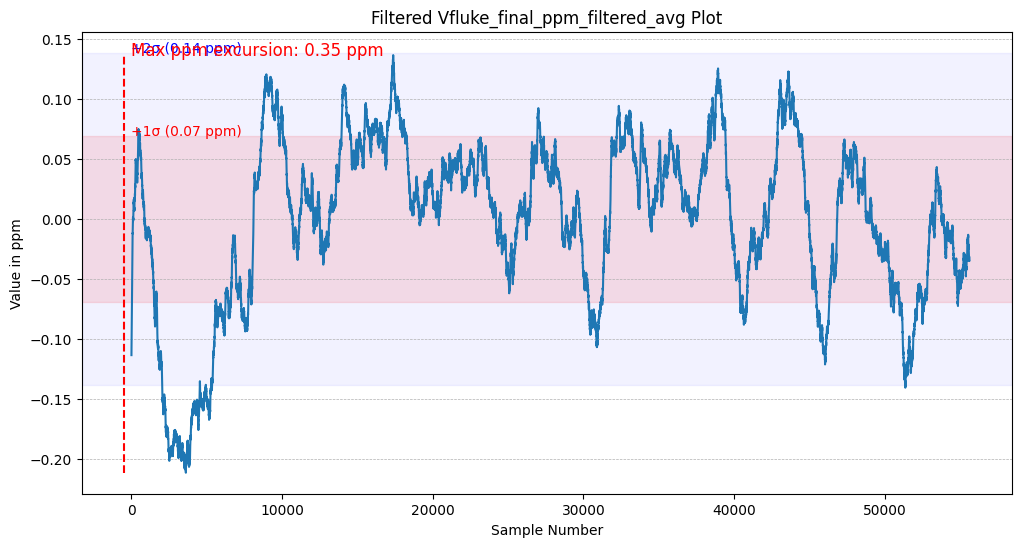

In [19]:
# Calculate V_final_ppm_filtered_avg based only on the fluke_data

Vfluke_final = np.absolute(Vfluke_no_offset)

Vfluke_final_avg = np.mean(Vfluke_final)

Vfluke_final_ppm = (Vfluke_final - Vfluke_final_avg) * 1e6 / Vfluke_final_avg


Vfluke_final_ppm_filtered = remove_outliers(Vfluke_final_ppm)

Vfluke_final_ppm_filtered_avg = centered_moving_average(Vfluke_final_ppm_filtered, 100)


# Plot 
plt.figure(figsize=(12, 6))
sigma = np.std(Vfluke_final_ppm_filtered_avg)
mean = np.mean(Vfluke_final_ppm_filtered_avg)

print(f'sigma: {sigma:.2f} ppm, mean: {mean:.2f} ppm')

# 1 Sigma bands
plt.axhspan(mean - sigma, mean + sigma, color='red', alpha=0.1, label='1 Sigma')
plt.text(0, mean + sigma, f'+1σ ({sigma:.2f} ppm)', color='r', horizontalalignment='left')

# 2 Sigma bands
plt.axhspan(mean - 2*sigma, mean + 2*sigma, color='blue', alpha=0.05, label='2 Sigma')
plt.text(0, mean + 2*sigma, f'+2σ ({2*sigma:.2f} ppm)',  color='b', horizontalalignment='left')

plt.plot(Vfluke_final_ppm_filtered_avg, label='Vfluke_final_ppm_filtered_avg')

ticks_interval = 0.05  # spacing in ppm

max_val = np.ceil(np.max(np.abs(Vfluke_final_ppm_filtered_avg)) / ticks_interval) * ticks_interval

y_ticks = np.arange(-max_val, max_val + ticks_interval, ticks_interval)
plt.yticks(y_ticks)

plt.grid(axis='y', linestyle='--', linewidth=0.5)

max_ppm_excursion = np.max(Vfluke_final_ppm_filtered_avg) - np.min(Vfluke_final_ppm_filtered_avg)

# print max ppm excursion
print('Maximum ppm excursion: ', np.max(Vfluke_final_ppm_filtered_avg) - np.min(Vfluke_final_ppm_filtered_avg))

print(f'During {len(Vfluke_final_ppm_filtered_avg)/3600} hours')

# highlight the maximum ppm excursion and quote the value on the plot

max_ppm_excursion_idx = np.argmax(Vfluke_final_ppm_filtered_avg)
plt.plot([-500,-500], [np.min(Vfluke_final_ppm_filtered_avg), np.max(Vfluke_final_ppm_filtered_avg)], 'r--')
plt.text( 0, Vfluke_final_ppm_filtered_avg[max_ppm_excursion_idx], f'Max ppm excursion: {max_ppm_excursion:.2f} ppm', fontsize=12, color='r')

plt.title('Filtered Vfluke_final_ppm_filtered_avg Plot')
plt.xlabel('Sample Number')
plt.ylabel('Value in ppm')
plt.savefig('img/filtered_vfluke_final_ppm_filtered_avg.png')
plt.show()





In [20]:
# we now do the same but averaging both V1, V2 and Fluke data

V1_V2_fluke_final = np.absolute((V1_no_offset + V2_no_offset + Vfluke_no_offset) / 3)

V1_V2_fluke_final_avg = np.mean(V1_V2_fluke_final)

V1_V2_fluke_final_ppm = (V1_V2_fluke_final - V1_V2_fluke_final_avg) * 1e6 / V1_V2_fluke_final_avg

V1_V2_fluke_final_ppm_filtered = remove_outliers(V1_V2_fluke_final_ppm)

V1_V2_fluke_final_ppm_filtered_avg = centered_moving_average(V1_V2_fluke_final_ppm_filtered, 100)

# and we plot the ppm excursion

plt.figure(figsize=(12, 6))
sigma = np.std(V1_V2_fluke_final_ppm_filtered_avg)
mean = np.mean(V1_V2_fluke_final_ppm_filtered_avg)

print(f'sigma: {sigma:.2f} ppm, mean: {mean:.2f} ppm')

# 1 Sigma bands
plt.axhspan(mean - sigma, mean + sigma, color='red', alpha=0.1, label='1 Sigma')
plt.text(0, mean + sigma, f'+1σ ({sigma:.2f} ppm)', color='r', horizontalalignment='left')

# 2 Sigma bands
plt.axhspan(mean - 2*sigma, mean + 2*sigma, color='blue', alpha=0.05, label='2 Sigma')
plt.text(0, mean + 2*sigma, f'+2σ ({2*sigma:.2f} ppm)',  color='b', horizontalalignment='left')

plt.plot(V1_V2_fluke_final_ppm_filtered_avg, label='V1_V2_fluke_final_ppm_filtered_avg')

ticks_interval = 0.05  # spacing in ppm

max_val = np.ceil(np.max(np.abs(V1_V2_fluke_final_ppm_filtered_avg)) / ticks_interval) * ticks_interval

y_ticks = np.arange(-max_val, max_val + ticks_interval, ticks_interval)
plt.yticks(y_ticks)

plt.grid(axis='y', linestyle='--', linewidth=0.5)

max_ppm_excursion = np.max(V1_V2_fluke_final_ppm_filtered_avg) - np.min(V1_V2_fluke_final_ppm_filtered_avg)

# print max ppm excursion
print('Maximum ppm excursion: ', np.max(V1_V2_fluke_final_ppm_filtered_avg) - np.min(V1_V2_fluke_final_ppm_filtered_avg))

print(f'During {len(V1_V2_fluke_final_ppm_filtered_avg)/3600} hours')

# highlight the maximum ppm excursion and quote the value on the plot

max_ppm_excursion_idx = np.argmax(V1_V2_fluke_final_ppm_filtered_avg)
plt.plot([-500,-500], [np.min(V1_V2_fluke_final_ppm_filtered_avg), np.max(V1_V2_fluke_final_ppm_filtered_avg)], 'r--')
plt.text( 0, V1_V2_fluke_final_ppm_filtered_avg[max_ppm_excursion_idx], f'Max ppm excursion: {max_ppm_excursion:.2f} ppm', fontsize=12, color='r')

plt.title('Filtered V1_V2_fluke_final_ppm_filtered_avg Plot')
plt.xlabel('Sample Number')
plt.ylabel('Value in ppm')
plt.savefig('img/filtered_v1_v2_fluke_final_ppm_filtered_avg.png')
plt.show()



sigma: 0.09 ppm, mean: 0.00 ppm
Maximum ppm excursion:  0.5135581156654894
During 15.412222222222223 hours


sigma: 0.10 ppm, mean: 0.00 ppm
Maximum ppm excursion:  0.5217602401222847
During 15.328333333333333 hours


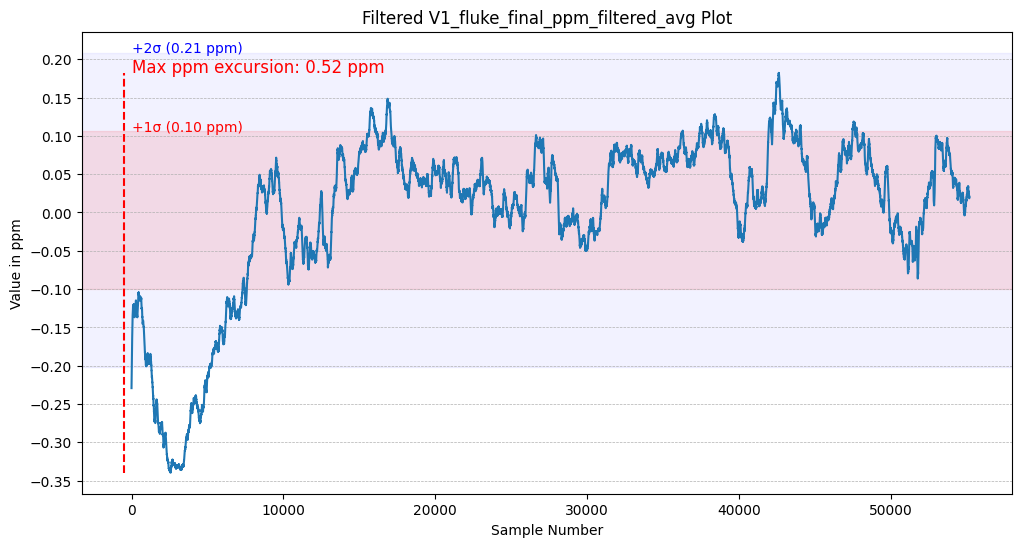

In [21]:
# Now produce the same graph but using only V1 and Vfluke

V1_fluke_final = np.absolute((V1_no_offset + Vfluke_no_offset) / 2)

V1_fluke_final_avg = np.mean(V1_fluke_final)

V1_fluke_final_ppm = (V1_fluke_final - V1_fluke_final_avg) * 1e6 / V1_fluke_final_avg

V1_fluke_final_ppm_filtered = remove_outliers(V1_fluke_final_ppm)

V1_fluke_final_ppm_filtered_avg = centered_moving_average(V1_fluke_final_ppm_filtered, 100)

# and we plot the ppm excursion

plt.figure(figsize=(12, 6))
sigma = np.std(V1_fluke_final_ppm_filtered_avg)
mean = np.mean(V1_fluke_final_ppm_filtered_avg)

print(f'sigma: {sigma:.2f} ppm, mean: {mean:.2f} ppm')

# 1 Sigma bands
plt.axhspan(mean - sigma, mean + sigma, color='red', alpha=0.1, label='1 Sigma')
plt.text(0, mean + sigma, f'+1σ ({sigma:.2f} ppm)', color='r', horizontalalignment='left')

# 2 Sigma bands
plt.axhspan(mean - 2*sigma, mean + 2*sigma, color='blue', alpha=0.05, label='2 Sigma')
plt.text(0, mean + 2*sigma, f'+2σ ({2*sigma:.2f} ppm)',  color='b', horizontalalignment='left')

plt.plot(V1_fluke_final_ppm_filtered_avg, label='V1_fluke_final_ppm_filtered_avg')

ticks_interval = 0.05  # spacing in ppm

max_val = np.ceil(np.max(np.abs(V1_fluke_final_ppm_filtered_avg)) / ticks_interval) * ticks_interval

y_ticks = np.arange(-max_val, max_val + ticks_interval, ticks_interval)

plt.yticks(y_ticks)

plt.grid(axis='y', linestyle='--', linewidth=0.5)

max_ppm_excursion = np.max(V1_fluke_final_ppm_filtered_avg) - np.min(V1_fluke_final_ppm_filtered_avg)

# print max ppm excursion

print('Maximum ppm excursion: ', np.max(V1_fluke_final_ppm_filtered_avg) - np.min(V1_fluke_final_ppm_filtered_avg))

print(f'During {len(V1_fluke_final_ppm_filtered_avg)/3600} hours')

# highlight the maximum ppm excursion and quote the value on the plot

max_ppm_excursion_idx = np.argmax(V1_fluke_final_ppm_filtered_avg)

plt.plot([-500,-500], [np.min(V1_fluke_final_ppm_filtered_avg), np.max(V1_fluke_final_ppm_filtered_avg)], 'r--')

plt.text( 0, V1_fluke_final_ppm_filtered_avg[max_ppm_excursion_idx], f'Max ppm excursion: {max_ppm_excursion:.2f} ppm', fontsize=12, color='r')

plt.title('Filtered V1_fluke_final_ppm_filtered_avg Plot')

plt.xlabel('Sample Number')

plt.ylabel('Value in ppm')

plt.savefig('img/filtered_v1_fluke_final_ppm_filtered_avg.png')

plt.show()

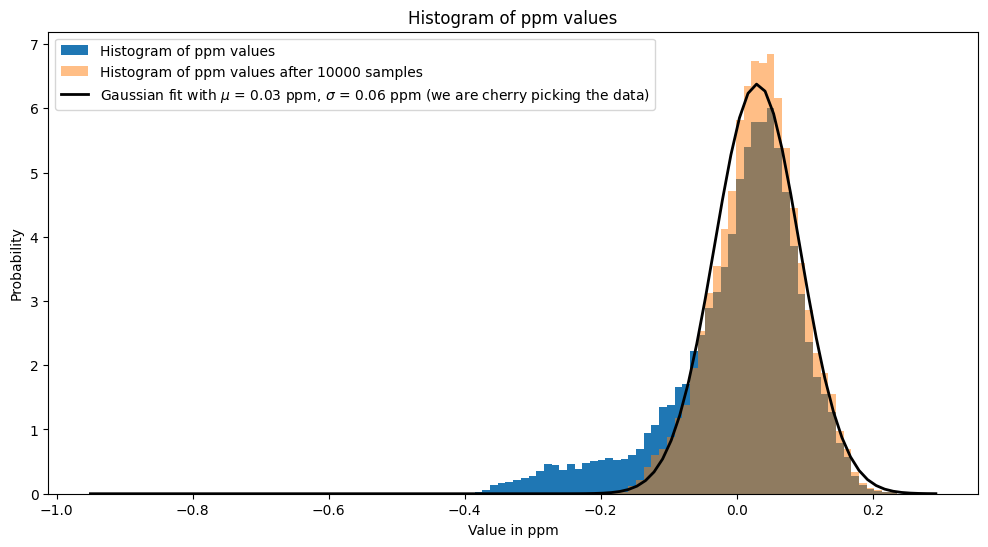

In [41]:
# now we want to make an histogram of the ppm values, and superimpose a gaussian fit 

# Plot the histogram of the ppm values
plt.figure(figsize=(12, 6))

plt.hist(V1_V2_fluke_final_ppm, bins=100, density=True, label='Histogram of ppm values')


# add an hystogram for data only after 10000 samples
plt.hist(V1_V2_fluke_final_ppm[10000:], bins=100, density=True, label='Histogram of ppm values after 10000 samples', alpha=0.5)

# Fit a gaussian to the histogram
from scipy.stats import norm
mu, std = norm.fit(V1_V2_fluke_final_ppm[10000:])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label=f'Gaussian fit with $\mu$ = {mu:.2f} ppm, $\sigma$ = {std:.2f} ppm (we are cherry picking the data)')



plt.title('Histogram of ppm values')
plt.xlabel('Value in ppm')
plt.ylabel('Probability')
plt.legend()
plt.savefig('img/histogram_ppm_values.png')
plt.show()

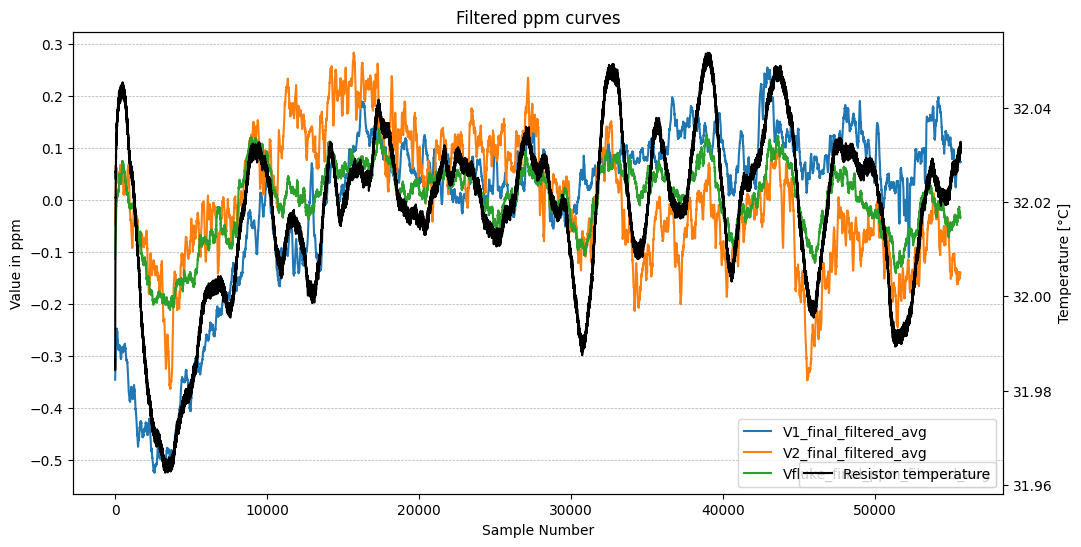

In [59]:
# print all three ppm curves in the same plot

plt.figure(figsize=(12, 6))

ax1 = plt.gca()
V1_final = np.absolute(V1_no_offset)

V1_final_filtered = remove_outliers(V1_final)

V1_final_filtered_avg = centered_moving_average(V1_final_filtered, 100)

V1_final_ppm_filtered_avg = (V1_final_filtered_avg - np.mean(V1_final_filtered_avg)) * 1e6 / np.mean(V1_final_filtered_avg)

V2_final = np.absolute(V2_no_offset) 

V2_final_filtered = remove_outliers(V2_final)

V2_final_filtered_avg = centered_moving_average(V2_final_filtered, 100)

V2_final_ppm_filtered_avg = (V2_final_filtered_avg - np.mean(V2_final_filtered_avg)) * 1e6 / np.mean(V2_final_filtered_avg)



ax1.plot(V1_final_ppm_filtered_avg, label='V1_final_filtered_avg')
ax1.plot(V2_final_ppm_filtered_avg, label='V2_final_filtered_avg')
ax1.plot(Vfluke_final_ppm_filtered_avg, label='Vfluke_final_ppm_filtered_avg')

plt.title('Filtered ppm curves')

# add ticks
ticks_interval = 0.05  # spacing in ppm
max_val = np.ceil(np.max(np.abs(V1_V2_fluke_final_ppm_filtered_avg)) / ticks_interval) * ticks_interval


ax1.grid(axis='y', linestyle='--', linewidth=0.5)

ax1.set_xlabel('Sample Number')
plt.ylabel('Value in ppm')
ax2 = ax1.twinx()

ax2.plot(Temperature, label='Resistor temperature', color='k')
ax2.set_ylabel('Temperature [°C]')
ax1.legend()
ax2.legend(loc='lower right')

plt.savefig('img/filtered_ppm_curves_plus_temp.png')
plt.show()




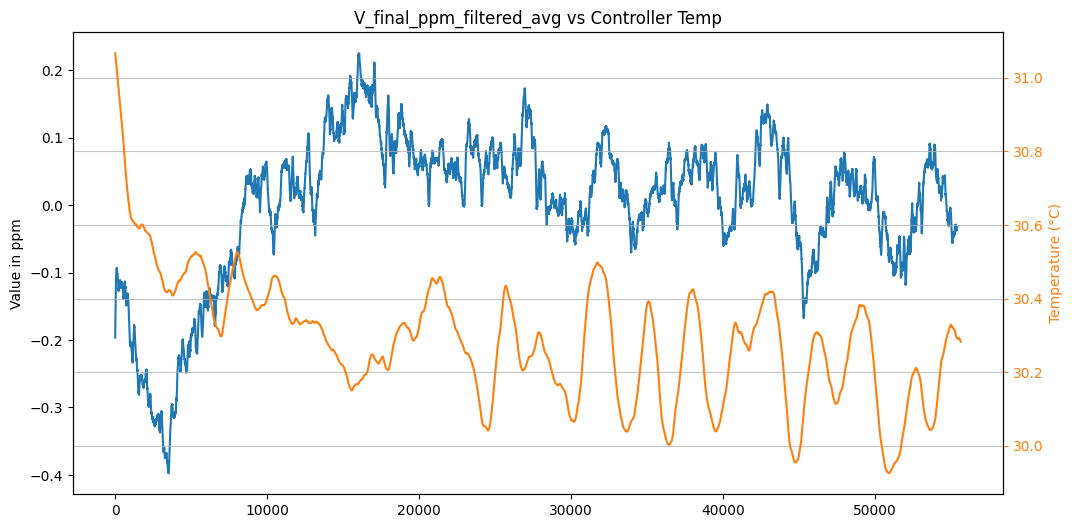

In [22]:

# Plot 3
plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax1.plot(V_final_ppm_filtered_avg, label='V_final_ppm_filtered')
ax1.set_ylabel('Value in ppm')

# Create a second y-axis to plot the controller temperature
if 'controller' in aligned_temps:
    ax2 = ax1.twinx() 
    ax2.plot(controller_temp_smoothed, label='Controller Temp', color='tab:orange')
    ax2.set_ylabel('Temperature (°C)', color='tab:orange')
    ax2.tick_params('y', colors='tab:orange')

plt.title('V_final_ppm_filtered_avg vs Controller Temp')
plt.xlabel('Sample Number')
plt.grid(axis='y', alpha=0.75)
plt.savefig('img/v_final_ppm_filtered_avg_vs_controller_temp.png')
plt.show()



In [23]:

# Plot 4
plt.figure(figsize=(12, 6))
ax_temp = plt.gca()
ax_temp.plot(Temperature, label='Resistor Temp', color='k', linewidth=2)


ax_temp.legend(loc="upper left")

# set axis label
ax_temp.set_ylabel('Resistor Temperature (°C)')

if 'controller' in aligned_temps:
    ax_controller = ax_temp.twinx()
    ax_controller.plot(controller_temp_smoothed, label='Controller Temp', color='tab:orange')
    ax_controller.set_ylabel('Controller Temperature (°C)', color='tab:orange')
    ax_controller.tick_params('y', colors='tab:orange')

plt.title('Temperature of the resistor and Controller')

plt.xlabel('Sample Number')
plt.legend(loc="upper right")
plt.grid(axis='y', alpha=0.75)
plt.savefig('img/resistor_temp_vs_controller_temp.png')
plt.show()

In [24]:
plt.figure(figsize=(24, 6))

# Calculate the mean value for Resistor Temperature as its set point
Temperature_normalized = Temperature - np.mean(Temperature)


# Plotting the normalized temperatures for the modules
for module, temps in aligned_temps.items():
  temps_normalized = np.array(temps) - np.mean(temps)
  plt.plot(temps_normalized, label=module)

# Plotting the normalized resistor temperature
plt.plot(Temperature_normalized, label='Resistor Temp', color='k', linewidth=2)

# force the y scale to be between -2 and 0.5
plt.ylim(-1.6, 1)

plt.xlabel('Sample Number')
plt.ylabel('Temperature Variation (°C)')
plt.legend(loc="lower right")
plt.title('Temperature Variations for all Modules and Resistor Temp')
plt.grid(axis='y', alpha=0.75)
plt.savefig('img/temperature_variations.png')
plt.show()

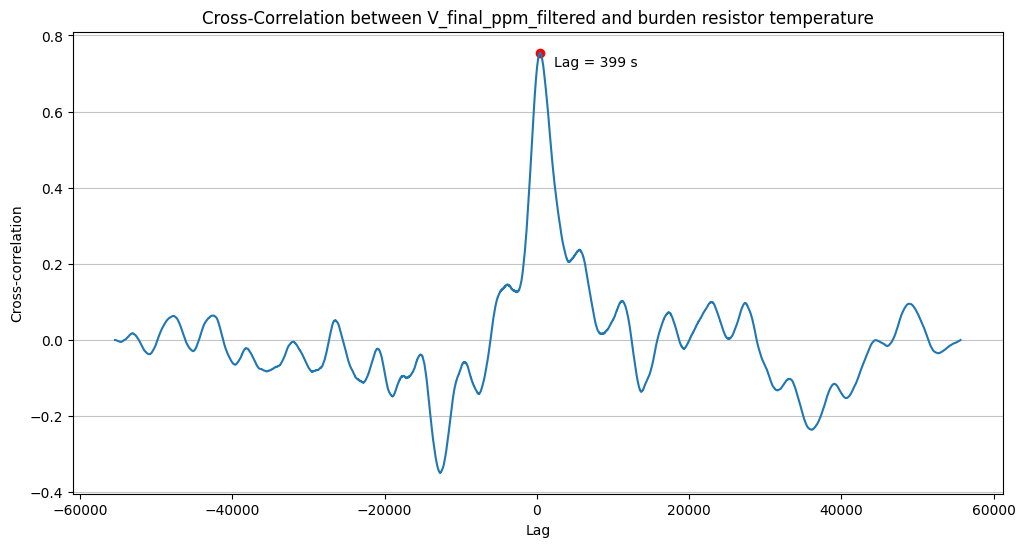

In [19]:
# Plotting for V_final_ppm_filtered and Temperature
plt.figure(figsize=(12, 6))
cross_corr_V_final, lags_V_final = compute_normalized_xcorr(Temperature, V_final_ppm_filtered, mode='full')


search_range = 1000  # The range to search for the maximum value in the cross-correlation
# Find the index of the maximum value in the cross-correlation within the restricted range
restrict_range_indices = np.where((lags_V_final >= -search_range) & (lags_V_final <= search_range))
max_index_V_final_restricted = np.argmax(cross_corr_V_final[restrict_range_indices])
max_lag_V_final_restricted = lags_V_final[restrict_range_indices][max_index_V_final_restricted]

plt.plot(lags_V_final, cross_corr_V_final)
plt.scatter(max_lag_V_final_restricted, cross_corr_V_final[restrict_range_indices][max_index_V_final_restricted], color='red')  # highlight the max value with a red dot
plt.annotate(f'Lag = {max_lag_V_final_restricted} s',
             (max_lag_V_final_restricted, cross_corr_V_final[restrict_range_indices][max_index_V_final_restricted]),
             xytext=(10,-10), textcoords='offset points')
plt.title('Cross-Correlation between V_final_ppm_filtered and burden resistor temperature')
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.grid(axis='y', alpha=0.75)
plt.savefig('img/cross_correlation_V_final_ppm_filtered_and_burden_resistor_temp.png')
plt.show()

In [22]:

# Plotting for Temperature and Controller Temp
plt.figure(figsize=(12, 6))
cross_corr_temp_controller, lags_temp_controller = compute_normalized_xcorr(Temperature, aligned_temps['controller'], mode='full')

# Find the index of the maximum value in the cross-correlation
max_index_temp_controller = np.argmax(cross_corr_temp_controller)
max_lag_temp_controller = lags_temp_controller[max_index_temp_controller]

plt.plot(lags_temp_controller, cross_corr_temp_controller)
plt.scatter(max_lag_temp_controller, cross_corr_temp_controller[max_index_temp_controller], color='red')  # highlight the max value with a red dot
plt.annotate(f'Lag = {max_lag_temp_controller} s',
             (max_lag_temp_controller, cross_corr_temp_controller[max_index_temp_controller]),
             xytext=(10,-10), textcoords='offset points')
plt.title('Cross-Correlation between burden resistor temperature and Controller Temp')
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.grid(axis='y', alpha=0.75)
plt.savefig('img/cross_correlation_burden_resistor_temp_and_controller_temp.png')
plt.show()

In [26]:
# calculate and plot the cross correlation of sin and cos

# Calculate the cross-correlation between sin and cos
cross_corr_sin_cos, lags_sin_cos = compute_normalized_xcorr(np.sin(np.linspace(0, 20*np.pi, 1000)), np.sin(np.linspace(0, 20*np.pi, 1000)), mode='full')

# Plot the cross-correlation
plt.figure(figsize=(12, 6))
plt.plot(lags_sin_cos, cross_corr_sin_cos)
plt.title('Cross-correlation between sin and cos')
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.grid(axis='y', alpha=0.75)
plt.show()